Dataset consists of 374 rows and 13 columns. Below is an explanation of each column.

1. Person ID: A unique identifier for each individual.
2. Gender: The gender of the person (Male/Female).
3. Age (years): The age of the person.
4. Occupation: The occupation or profession of the person.
5. Sleep Duration (hours): The number of hours the person sleeps per day.
6. Quality of Sleep (scale: 1-10): A subjective rating of the quality of sleep, ranging from 1 to 10.
7. Physical Activity Level (minutes/day): The number of minutes the person engages in physical activity daily.
8. Stress Level (scale: 1-10): A subjective rating of the stress level experienced by the person, ranging from 1 to 10.
9. BMI Category: The BMI category of the person (e.g., Underweight, Normal, Overweight).
10. Blood Pressure (systolic/diastolic): The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure.
11. Heart Rate (bpm): The resting heart rate of the person in beats per minute.
12. Daily Steps: The number of steps the person takes each day.
13. Sleep Disorder: Indicates whether the individual has a sleep disorder (e.g., None, Insomnia, Sleep Apnea).


Target  : Sleep Disorder

## Install dependensi

In [33]:
!pip install langchain_community
!pip install replicate

In [34]:
!pip install pandas
!pip install -U langchain langchain-community langchain-experimental replicate

## Setup Token & Model LLM

In [35]:
import os
from google.colab import userdata
api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token


In [36]:
from langchain_community.llms import Replicate
from langchain_experimental.agents.agent_toolkits.pandas.base import create_pandas_dataframe_agent
from langchain.agents import AgentExecutor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Define the model
llm = Replicate(
  model="ibm-granite/granite-3.3-8b-instruct",
)

## Load Dataset

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset (1).csv")
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [38]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna(value='Normal')

In the original dataset, the values of Sleep Disorder are Insomnia, Sleep Apnea, and None which indicates to not having any sleeping disorder. But when imported, the value None is automatically read as missing values (NaN). To fix this problem, I decided to impute the missing values with "Normal".

## Visualisasi

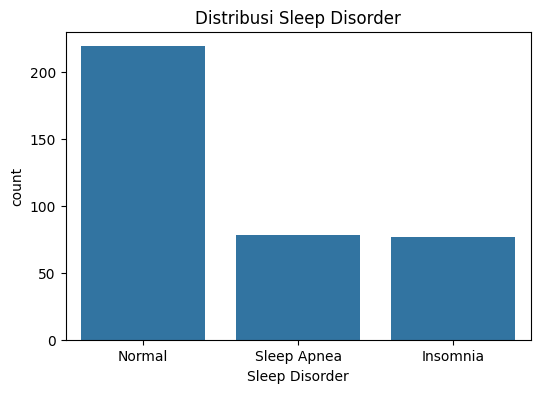

In [39]:
# Distribusi Sleep Disorder
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sleep Disorder')
plt.title("Distribusi Sleep Disorder")
plt.show()

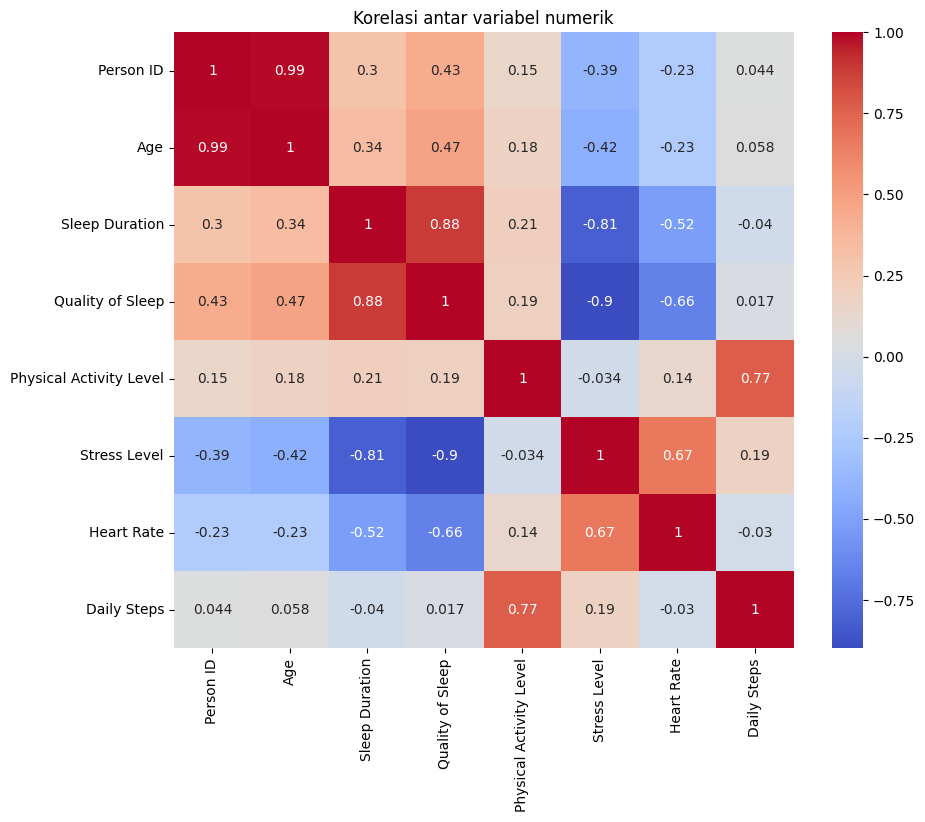

In [40]:
# Korelasi Numerik
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar variabel numerik")
plt.show()

The heatmap shows that Sleep Disorder has a negative correlation with Stress Level and a positive correlation with Physical Activity Level. Person ID is unnecessary and is not a meaningful feature for correlation.

## Statistik Deskriptif

In [41]:
# Ambil subset data yang hanya numerik untuk AI Agent
df_numeric = df.select_dtypes(include='number').copy()

In [42]:
agent_safe = create_pandas_dataframe_agent(
    llm=llm,
    df=df_numeric,
    verbose=True,
    allow_dangerous_code=True
)


In [43]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Person ID,374.0,187.500000,108.108742,1.0,94.25,187.5,280.75,374.0
Age,374.0,42.184492,8.673133,27.0,35.25,43.0,50.00,59.0
Sleep Duration,374.0,7.132086,0.795657,5.8,6.40,7.2,7.80,8.5
Quality of Sleep,374.0,7.312834,1.196956,4.0,6.00,7.0,8.00,9.0
Physical Activity Level,374.0,59.171123,20.830804,30.0,45.00,60.0,75.00,90.0
Stress Level,374.0,5.385027,1.774526,3.0,4.00,5.0,7.00,8.0
Heart Rate,374.0,70.165775,4.135676,65.0,68.00,70.0,72.00,86.0
Daily Steps,374.0,6816.844920,1617.915679,3000.0,5600.00,7000.0,8000.00,10000.0


In [44]:
summary = df.select_dtypes(include='number').describe().transpose().round(2).to_string()

prompt = f"""
Ringkas data numerik berikut:

{summary}

Berdasarkan data di atas:
- Sebutkan 3 insight penting.
- Sebutkan 3 rekomendasi praktis untuk meningkatkan kualitas tidur.

Jawab dengan bullet points.
"""
output = llm.predict(text=prompt)
print(output)


### Insight Penting:

- **Person ID**: The maximum count of person IDs is 374, indicating that data is collected from 374 unique individuals.

- **Age**: The average age of individuals is 42.18 years, with a standard deviation of 8.67, suggesting a relatively consistent age group in the dataset.

- **Physical Activity Level**: The highest reported physical activity level is 90, with an average of 60, indicating that the group tends to be moderately active.

### Rekomendasi Praktis Untuk Meningkatkan Kualitas Tidur:

- **Consistent Sleep Schedule**: Based on the mean and standard deviation of sleep duration (7.13 hours with a small variation), maintaining a regular sleep schedule can help stabilize sleep patterns and improve overall sleep quality.

- **Reduce Stress**: The average stress level is 5.39 (on an unspecified scale), suggesting that stress management techniques such as meditation, yoga, or other relaxation exercises might help lower stress and enhance sleep quality.

- **Incr

## Insight Mengenai Dataset


In [45]:
prompt_corr = f"""
Berikut ringkasan statistik data numerik:

{summary}

Pertanyaan:
Variabel apa yang paling berkorelasi dengan Sleep Disorder?
Sertakan nilai korelasi dan penjelasan singkat berdasarkan data.
"""

# 3) Call the LLM with predict(text=...)
insight_1 = llm.predict(text=prompt_corr)

# 4) Print the result
print("💡 Insight 1 – Korelasi Terkuat:")
print(insight_1)


💡 Insight 1 – Korelasi Terkuat:
To determine which variable is most correlated with Sleep Disorder, we need additional information about the presence or absence of sleep disorders in the dataset, which isn't provided here. However, we can analyze the given data to infer potential relationships.

Since we don't have direct information on sleep disorders, we'll examine the relationships between the variables that might be indirectly related to sleep quality. Here, we'll consider variables like Sleep Duration, Quality of Sleep, and Stress Level as potential indicators.

1. **Sleep Duration vs. Quality of Sleep**: Both have high values (mean = 7.13 and 7.31, respectively) and narrow standard deviations (0.80 and 1.20), indicating consistency in sleep patterns and quality. A positive correlation is expected here, as longer and higher-quality sleep durations are linked.

2. **Quality of Sleep vs. Stress Level**: With mean values of 7.31 and 5.39 respectively, Quality of Sleep is higher than 

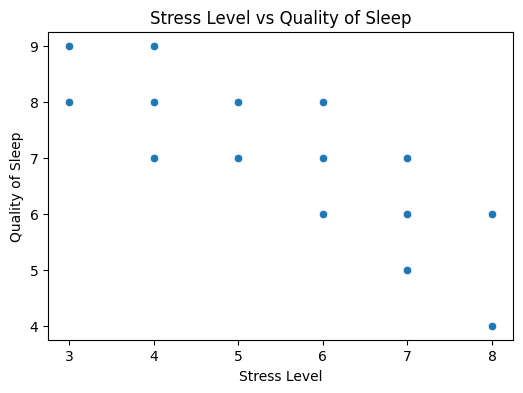

Interpretasi grafik tersebut adalah saat stress level (X) meningkat, kualitas tidur (Y) menurun secara negatif. Dalam konteks ini, terdapat korelasi invers (negative correlation) antara stress level dan kualitas tidur. Jadi, sebagai contoh, saat stress level naik, kualitas tidur menjadi lebih buruk, dan sebaliknya. Ini bisa dianggap sebagai indikator bahwa stress memiliki dampak yang langsung terhadap kualitas tidur.


In [46]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="Stress Level", y="Quality of Sleep")
plt.title("Stress Level vs Quality of Sleep")
plt.show()

explain_plot = """
Terdapat scatter plot antara Stress Level (X) dan Quality of Sleep (Y),
yang menunjukkan tren negatif. Apa interpretasi dari grafik tersebut?
"""
print(llm.predict(text=explain_plot))


In [47]:
# Ambil top 3 variabel teratas dari korelasi biner
top3 = corrs.drop('SleepDisorderBinary').head(3).to_string()

# Buat prompt rekomendasi
prompt_recs = f"""
Berdasarkan dataset tidur dan gaya hidup, tiga variabel teratas yang berkorelasi dengan Sleep Disorder adalah:

{top3}

Berikan tiga rekomendasi praktis (actionable) untuk mengurangi Sleep Apnea dan Insomnia,
berdasarkan pola pada variabel-variabel tersebut.
Jawab dalam bullet points.
"""

# Panggil LLM langsung
insight_2 = llm.predict(text=prompt_recs)

# Cetak hasil
print("✅ Insight 2 – Recommendations:")
print(insight_2)

✅ Insight 2 – Recommendations:
- **Improve Sleep Hygiene:** Establish a regular sleep schedule, maintaining consistent sleep and wake times even on weekends. This can help regulate the body's internal clock and promote better sleep quality.

- **Optimize Sleep Environment:** Ensure the sleep environment is conducive to restful sleep. This includes maintaining a cool, dark, and quiet room, and using comfortable bedding. Additionally, limit exposure to electronic devices before bedtime, as the blue light emitted can interfere with the production of melatonin, a hormone that regulates sleep.

- **Address Underlying Conditions:** If age is a factor, consider age-related sleep changes and consult a healthcare professional for advice on managing them. For sleep duration, aim for 7-9 hours per night for adults, and address any underlying medical, neurological, or psychiatric conditions that may affect sleep patterns. For quality of sleep, consider techniques such as relaxation exercises, cogn

## AI Support Explanation

In [48]:
explain_prompt = """
Jelaskan bagaimana peran AI (model LLM seperti IBM Granite) dapat membantu dalam proses analisis data.
Berikan contoh penggunaannya dan manfaatnya dalam mencari insight.
"""
print(llm.predict(text=explain_prompt))


AI model seperti IBM Granite, yang berbasis pada arsitektur LLM (Large Language Model), dapat membantu dalam proses analisis data dengan beberapa cara:

1. **Pemrosesan Bahasa Natural (NLP)**: Model LLM terbaik dalam pemrosesan dan generasi teks. Dalam konteks analisis data, AI dapat membaca dan memahami teks berformat luas seperti laporan, surat, sosial media, dan lainnya. Ini memungkinkan pengekstraksi informasi, sentiment analisis, dan pemahaman konteks dengan tingkat yang tidak mungkin dikelola manual.

2. **Identifikasi Ruang Temuan**: AI dapat membantu identifikasi kunci variabel, tren, atau anomalis dalam data besar. Misalnya, dalam analisis pasar, model dapat mendeteksi perubahan dalam perkembangan harga, trend konsumen, atau perubahan dalam perilaku pasar yang lain tanpa perlu diprogram secara manual.

3. **Prediksi dan Simulasi**: Dengan pelatihan pada data sejarah, model LLM dapat digunakan untuk membuat prediksi masa keluaran atau mengidentifikasi potensi kesempatan. Misaln